In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import spacy
import pickle
import itertools
import seaborn as sns
import time
from tqdm import tqdm

## Use Spacy to vectorize lyrics

In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
tqdm.pandas()

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
df['spacy'] = df.clean_lyrics.progress_apply(lambda x: nlp(x))

100%|██████████| 348834/348834 [2:13:23<00:00, 43.59it/s]  


In [8]:
#save dataframe with spacy column
df.to_csv('df_w_spacy.csv')

In [6]:
#get vector representation for lyrics utilizing spacy
spacy_df = pd.DataFrame(np.vstack([x.vector for x in df.spacy]))

In [7]:
#save dataframe in case of kernel failure
spacy_df.to_csv('spacy_df.csv')

## Load Dataframes

In [2]:
df = pd.read_csv('modeling_df.csv', index_col = 0)

In [3]:
spacy_df = pd.read_csv('spacy_df.csv', index_col = 0)

## Checking Class Balance

In [4]:
# check out the class balance
df['genre'].value_counts(normalize=True)

Pop/R&B         0.383813
Rock/Metal      0.298824
Hip-Hop/Rap     0.191965
Country/Folk    0.125398
Name: genre, dtype: float64

There is a bit of a class imbalance here, the Pop/R&B genre outweighs all other genres. We will downsample here for two reasons. First this will help alleviate the class imbalance issue and second it will help the models fit quicker as the decision tree/random forest took hours to fit to the training set with the full dataframe.

### StopWords

In [5]:
# create stopwords and update as spacy lemmatizer converts all pronouns (i, we, us, etc..) to -PRON-
stopwords_list = stopwords.words('english')+['pron', '-PRON-', 'br']

In [75]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Modeling

## Baseline

From checking our classes we have shown that our classes are a bit imbalanced. we will fit a dummy classifier to get a baseline model after downsampling our classes.

In [60]:
# set datframe for dummyclassifier
X = df

# Create target variable for dummyclassifier
y = df['genre']

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333)

## Downsample training set

In [61]:
# set up dataframes by genre to downsample (we will downsample to size of Country_df)
Country_df = X_train[X_train['genre'] == 'Country/Folk']
Pop_df = X_train[X_train['genre'] == 'Pop/R&B']
Rock_df = X_train[X_train['genre'] == 'Rock/Metal']
Rap_df = X_train[X_train['genre'] == 'Hip-Hop/Rap']

In [62]:
# downsample pop genre
Pop_downsampled = resample(Pop_df,
                           replace = False, # sample without replacement
                           n_samples = len(Country_df), # match minority n
                           random_state = 333) # reproducible results

In [63]:
# downsample rep genre
Rap_downsampled = resample(Rap_df,
                           replace = False, # sample without replacement
                           n_samples = len(Country_df), # match minority n
                           random_state = 333) # reproducible results

In [64]:
# downsample rock genre
Rock_downsampled = resample(Rock_df,
                            replace = False, # sample without replacement
                            n_samples = len(Country_df), # match minority n
                            random_state = 333) # reproducible results

In [65]:
# combine dataframes for modeling
# combine minority and downsampled genres
downsampled = pd.concat([Pop_downsampled, Country_df, Rock_downsampled, Rap_downsampled])

### Fit dummy classifier

In [66]:
downsampled.reset_index(drop = True, inplace = True)
test_x = X_test.reset_index(drop = True)
test_y = y_test.reset_index(drop = True)

In [67]:
y_train = downsampled['genre']
X_train = downsampled.drop(['genre'], axis = 1)

y_test = test_y
X_test = test_x.drop(['genre'], axis = 1)

In [68]:
# DummyClassifier to predict only most frequent class
dummy = DummyClassifier(strategy='uniform').fit(X_train, y_train)
dummy_pred_test = dummy.predict(X_test)

In [69]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(dummy_pred_test, y_test))
print()
# checking F1
print('Test F1 score: ', f1_score(dummy_pred_test, y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, dummy_pred_test))

Test Accuracy score:  0.250478734992948

Test F1 score:  0.24015296209533898

Confusion matrix test set: 
 [[2747 2726 2732 2699]
 [4287 4213 4151 4172]
 [8245 8399 8458 8250]
 [6642 6486 6576 6426]]


this is will be our baseline model and what we will compare our models with

## TFIDF

In [70]:
# vectorize our predictor column, n_gram range was chosen as we found having groups of words increased 
# our score, max_features of 50,000 was used as anything bigger than that kept making the kernel crash
vect = TfidfVectorizer(ngram_range=(1, 3), max_features = 50000, stop_words=stopwords_list)
    
#fit/transform train set and transform test set
X_train = vect.fit_transform(X_train['cleaned_lemmed_lyrics'])
X_test = vect.transform(X_test['cleaned_lemmed_lyrics'])
    
# make into a dataframe with the ngrams as column names
X_train = pd.DataFrame(X_train.toarray(), columns=vect.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vect.get_feature_names())

### Naive Bayes no engineered features

In [71]:
%%time

#INSTANTIATE NB Classifier
Naive = MultinomialNB()

#fit to training set
Naive.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive.predict(X_train)
y_pred_nb_test = Naive.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test))

Train Accuracy score:  0.5131170254879869
Test Accuracy score:  0.398536848261074

Train F1 score:  0.5162595816912312
Test F1 score:  0.39785289987283884

Confusion matrix test set: 
 [[ 6123   975  1864  1942]
 [ 3047  7136  3061  3579]
 [ 9203  5021  9591  9537]
 [ 5787  3170  5267 11906]]
CPU times: user 1min 43s, sys: 3min 8s, total: 4min 52s
Wall time: 3min 7s


In [76]:
cm = confusion_matrix(y_test, y_pred_nb_test)
classes = ['Country', 'Hip_Hop/Rap', 'Pop/R&B', 'Rock/Metal']

Confusion Matrix, without normalization
[[ 6123   975  1864  1942]
 [ 3047  7136  3061  3579]
 [ 9203  5021  9591  9537]
 [ 5787  3170  5267 11906]]


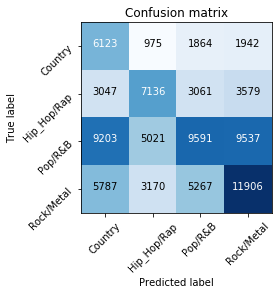

In [77]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

## Naive Bayes with engineered features

In [19]:
#add engineered features to X_train
X_train['num_lines'] = downsampled['num_lines']
X_train['num_words'] = downsampled['num_words']
X_train['words_per_line'] = downsampled['words_per_line']
X_train['unique_words'] = downsampled['unique_words']
X_train['explicit'] = downsampled['explicit']

In [22]:
# add engineered features to x_test
X_test['num_lines'] = test_x['num_lines']
X_test['num_words'] = test_x['num_words']
X_test['words_per_line'] = test_x['words_per_line']
X_test['unique_words'] = test_x['unique_words']
X_test['explicit'] = test_x['explicit']

In [23]:
%%time

#INSTANTIATE NB Classifier
Naive_feat = MultinomialNB()

#fit to training set
Naive_feat.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive_feat.predict(X_train)
y_pred_nb_test = Naive_feat.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test))

Train Accuracy score:  0.43547306556228876
Test Accuracy score:  0.38453599972479907

Train F1 score:  0.4380378860043653
Test F1 score:  0.3761272495449304

Confusion matrix test set: 
 [[ 6350   471  2639  1444]
 [ 3863  5491  4809  2660]
 [10890  2752 12334  7376]
 [ 7596  1708  7466  9360]]
CPU times: user 11min 2s, sys: 11min 14s, total: 22min 17s
Wall time: 22min 56s


## Spacy

In [25]:
predictors = spacy_df
target = df['genre']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=333)

In [27]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our engineered features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# turn the arrays into dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Naive Bayes no engineered features

In [28]:
%%time

#INSTANTIATE NB Classifier
Naive_sp = MultinomialNB()

#fit to training set
Naive_sp.fit(X_train_scaled,y_train)

#predict on train and test set
y_pred_nb_train = Naive_sp.predict(X_train_scaled)
y_pred_nb_test = Naive_sp.predict(X_test_scaled)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test))

Train Accuracy score:  0.38427520305781177
Test Accuracy score:  0.3824375924503205

Train F1 score:  0.5551960091912173
Test F1 score:  0.5532800822819983

Confusion matrix test set: 
 [[    0     0 10904     0]
 [    0     0 16823     0]
 [    0     0 33352     0]
 [    0     0 26130     0]]
CPU times: user 6.35 s, sys: 45.2 ms, total: 6.39 s
Wall time: 3.91 s


Naive Bayes model is just picking dominant class, we will need to choose a different model

## Decision Tree no engineered features

In [60]:
# look at cross validation scores to see if model should be fitted
# instantiate the decision tree classifier
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

# fit it to our training set and evaluate
cross_val_score(tree, X_train, y_train, cv=10, n_jobs=-1)

array([0.34656225, 0.34925007, 0.34845368, 0.35270109, 0.34705999,
       0.34755774, 0.35183833, 0.34908415, 0.34775684, 0.34905097])

Naive Bayes model performed better but it was just choosing dominant class so we will fit a model to see how it performs against random forest

In [29]:
%%time

# INSTANTIATE DECISION TREE MODEL
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_tree_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test))

Train Accuracy score:  0.9968389870998566
Test Accuracy score:  0.34207478585925766

Train F1 score:  0.9968367924745904
Test F1 score:  0.34142040622155917

Confusion matrix test set: 
 [[ 2127  1787  4094  2896]
 [ 1782  5028  5809  4204]
 [ 4314  5932 13532  9574]
 [ 3170  4303  9512  9145]]
CPU times: user 3min 19s, sys: 287 ms, total: 3min 19s
Wall time: 3min 19s


## Random Forest no engineered features

In [73]:
# look at cross validation scores to see if model should be fitted
#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

# fit it to our training set and evaluate
cross_val_score(rfc, X_train, y_train, cv=10, n_jobs=-1)

array([0.46047916, 0.46011415, 0.46519113, 0.46256968, 0.46077781,
       0.46084417, 0.46323334, 0.45918503, 0.46144147, 0.46220467])

this is performing better than decision tree so we will fit a model

In [30]:
%%time

#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

#fit to training set
rfc.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train = rfc.predict(X_train)
y_pred_rfc_test = rfc.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_rfc_test,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test))

Train Accuracy score:  0.996942188246536
Test Accuracy score:  0.4479468862158722

Train F1 score:  0.9969403568698881
Test F1 score:  0.4858380772831753

Confusion matrix test set: 
 [[  921   401  8011  1571]
 [  218  4611  9651  2343]
 [  562  1936 25412  5442]
 [  348   918 16743  8121]]
CPU times: user 19min 58s, sys: 4.29 s, total: 20min 3s
Wall time: 1min 30s


## Naive Bayes with engineered features

In [78]:
engineered = df.drop(columns = ['artist', 'lyrics', 'clean_lyrics', 'better_lyrics', 'cleaned_lemmed_lyrics', 'lines', 'genre'])

In [79]:
predictors = pd.concat([spacy_df, engineered], axis = 1)
target = df['genre']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=333)

In [81]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our engineered features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# turn the arrays into dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [82]:
%%time

#INSTANTIATE NB Classifier
Naive_sp_feat = MultinomialNB()

#fit to training set
Naive_sp_feat.fit(X_train_scaled,y_train)

#predict on train and test set
y_pred_nb_train_sp_feat = Naive_sp_feat.predict(X_train_scaled)
y_pred_nb_test_sp_feat = Naive_sp_feat.predict(X_test_scaled)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train_sp_feat, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test_sp_feat, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train_sp_feat, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_nb_test_sp_feat,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test_sp_feat))

Train Accuracy score:  0.3843248924988055
Test Accuracy score:  0.3824605258631563

Train F1 score:  0.5551531515721055
Test F1 score:  0.5531561305024378

Confusion matrix test set: 
 [[    0     0 10904     0]
 [    0     8 16815     0]
 [    0     6 33346     0]
 [    0     0 26130     0]]
CPU times: user 5.56 s, sys: 212 ms, total: 5.78 s
Wall time: 3.39 s


In [83]:
cm = confusion_matrix(y_test, y_pred_nb_test_sp_feat)
classes = ['Country', 'Hip-Hop/Rap', 'Pop/R&B', 'Rock/Metal']

Confusion Matrix, without normalization
[[    0     0 10904     0]
 [    0     8 16815     0]
 [    0     6 33346     0]
 [    0     0 26130     0]]


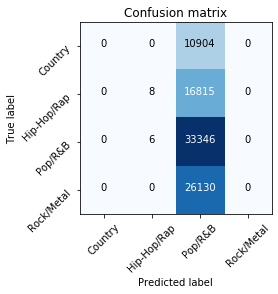

In [84]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

for the most part this is still choosing dominant class with the exception a few instances we will move on to other models to see how they perform

## Decision Tree with engineered features

In [68]:
# look at cross validation scores to see if model should be fitted
# instantiate the decision tree classifier
tree_feat = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

# fit it to our training set and evaluate
cross_val_score(tree_feat, X_train, y_train, cv=10, n_jobs=-1)

array([0.35611893, 0.3553889 , 0.36142819, 0.35744624, 0.35157287,
       0.35605256, 0.35890629, 0.35605256, 0.35472525, 0.35532254])

same as with our model without engineered features this model is performing worse than naive bayes but we will still fit a model as naive bayes is sticking to one class

In [35]:
%%time

# INSTANTIATE DECISION TREE MODEL
tree_feat = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree_feat.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train_feat = tree_feat.predict(X_train)
y_pred_tree_test_feat = tree_feat.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train_feat, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test_feat, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train_feat, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_tree_test_feat,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test_feat))

Train Accuracy score:  0.9976531294792165
Test Accuracy score:  0.3494134779667236

Train F1 score:  0.9976518522653014
Test F1 score:  0.348878888039867

Confusion matrix test set: 
 [[ 2270  1656  4054  2924]
 [ 1783  5160  5782  4098]
 [ 4274  5907 13778  9393]
 [ 3087  4204  9575  9264]]
CPU times: user 3min 25s, sys: 312 ms, total: 3min 25s
Wall time: 3min 25s


## Random Forest with engineered features

In [69]:
# look at cross validation scores to see if model should be fitted
#INSTANTIATE RANDOM FOREST MODEL
rfc_feat = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

# fit it to our training set and evaluate
cross_val_score(rfc_feat, X_train, y_train, cv=10, n_jobs=-1)

array([0.46844306, 0.46738121, 0.47109769, 0.46691664, 0.46548978,
       0.4664189 , 0.46980356, 0.46535705, 0.46718211, 0.47156225])

this is performing better than decision tree so we will fit a model

In [85]:
%%time

#INSTANTIATE RANDOM FOREST MODEL
rfc_feat = RandomForestClassifier(random_state = 333, class_weight='balanced', n_jobs = -1)

#fit to training set
rfc_feat.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train_feat = rfc_feat.predict(X_train)
y_pred_rfc_test_feat = rfc_feat.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train_feat, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test_feat, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train_feat, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_rfc_test_feat,y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test_feat))

Train Accuracy score:  0.9977257525083612
Test Accuracy score:  0.45326743799378505

Train F1 score:  0.9977246583920979
Test F1 score:  0.48597105203225743

Confusion matrix test set: 
 [[ 1119   404  7729  1652]
 [  286  5123  9113  2301]
 [  664  2119 24921  5648]
 [  404  1034 16326  8366]]
CPU times: user 19min 9s, sys: 6.21 s, total: 19min 15s
Wall time: 1min 23s


In [86]:
cm = confusion_matrix(y_test, y_pred_rfc_test_feat)
classes = ['Country', 'Hip_Hop/Rap', 'Pop/R&B', 'Rock/Metal']

Confusion Matrix, without normalization
[[ 1119   404  7729  1652]
 [  286  5123  9113  2301]
 [  664  2119 24921  5648]
 [  404  1034 16326  8366]]


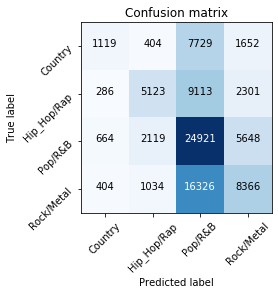

In [87]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [63]:
# print out report
print(classification_report(y_test, y_pred_rfc_test_feat, target_names=list(target.unique())))

              precision    recall  f1-score   support

     Pop/R&B       0.45      0.10      0.16     12097
 Hip-Hop/Rap       0.59      0.31      0.40     19391
Country/Folk       0.45      0.78      0.57     39934
  Rock/Metal       0.47      0.29      0.36     29032

    accuracy                           0.46    100454
   macro avg       0.49      0.37      0.37    100454
weighted avg       0.48      0.46      0.43    100454



In [39]:
#pickle our model to use with generated lyrics
pickle_out = open("rfc_mod.pickle","wb")
pickle.dump(rfc_feat, pickle_out)
pickle_out.close()

## Grid search best model to see if we can improve it

In [16]:
#SET PARAMATER GRID
param_grid_forest = { 
    'n_estimators': [75,100,125],
    'criterion': ['gini', 'entropy'],
    'max_leaf_nodes': [ 18, 19, 21, 23],
    'max_depth': [9, 10, 12],
    'max_features': ['auto', 'log2']
    }

grid_search_forest = GridSearchCV(estimator = rfc_feat, param_grid = param_grid_forest,cv = 5, n_jobs = -1)

In [ ]:
grid_search_forest.fit(X_train,y_train)
forest_params = grid_search_forest.best_params_
print(forest_params)

In [ ]:
forest_grid = RandomForestClassifier(**forest_params, random_state = 333,class_weight = 'balanced', n_jobs = -1)

forest_grid.fit(X_train, y_train)

y_pred_grid_train = forest_grid.predict(X_train)
y_pred_grid_test = forest_grid.predict(X_test)

# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_grid_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_grid_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_grid_train, y_train, average = 'weighted'))
print('Test F1 score: ', f1_score(y_pred_grid_test, y_test, average = 'weighted'))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_grid_test))

## Conclusion

Random Forest with engineered features is our best model, although not by a huge margin. Naive Bayes using Spacy vectorization seems to be just predicting the majority class in most cases. Naive Bayes TF-IDF Model is a good runner up but it as it does better than any of the decision trees models.